# Classificação de reservas de hotel - será cancelada ou não?
## UFRJ 2022.2 - Introdução à Aprendizagem de Máquina

- Rafael: SVM e Naive Bayes
    - Github: https://github.com/RafaelxFernandes/Machine-Learning-22.2/blob/rafael/%C3%9Altima%20chance/SVM_NaiveBayes.ipynb
- Sidney: Regressão Logística, KNN e Árvore de Decisão 
    - Github: https://github.com/RafaelxFernandes/Machine-Learning-22.2/blob/sidney/%C3%9Altima%20chance/KNN_DecisionTree_LogisticsRegression.ipynb

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

## Base de dados

Disponível em https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

A coluna "Booking_ID" foi deletada pois continha apenas os identificadores únicos das reservas, e tais valores são iguais aos índices do próprio DataFrame com que trabalharemos.

In [2]:
df = pd.read_csv('Dados/Hotel Reservations.csv')
df.drop('Booking_ID', axis = 1, inplace = True)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


## Tratando os dados

Realizado com base nos slides da Aula 1 - Base de Dados e Outliers

### Checando se há valores nulos
Nenhuma coluna possui valores nulos.

In [3]:
df.isnull().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

### Checando se há valores duplicados
Há 10.275 valores duplicados, que serão removidos, restando assim 26.000 instâncias.

In [4]:
df.duplicated().sum()

10275

In [5]:
df.drop_duplicates(inplace = True)

### Checando colunas

Os valores abaixo parecem estar dentro de um intervalo aceitável, segundo às suas respectivas descrições. Entretanto, vamos entender melhor os seus comportamento com análises mais específicas.

In [6]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000,26000.000000
mean,1.890000,0.141231,0.882385,2.261923,0.042115,66.452846,2017.850269,7.332923,15.750231,0.032769,0.028538,0.213115,105.695838,0.741962
std,0.528702,0.462502,0.887371,1.512341,0.200856,68.606799,0.356814,3.138925,8.849394,0.178035,0.408891,2.068243,37.876592,0.815109
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,12.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.750000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,44.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,100.000000,1.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,100.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,127.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


Precisamos transformar a coluna "booking_status" de "object" em valores inteiros para realizarmos os métodos de classificação. Dado que as colunas "type_of_meal_plan", "room_type_reserved" e "market_segment_type" podem desempenhar um papel importante na nossa classificação, realizaremos a mesma transformação nelas.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 36273
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          26000 non-null  int64  
 1   no_of_children                        26000 non-null  int64  
 2   no_of_weekend_nights                  26000 non-null  int64  
 3   no_of_week_nights                     26000 non-null  int64  
 4   type_of_meal_plan                     26000 non-null  object 
 5   required_car_parking_space            26000 non-null  int64  
 6   room_type_reserved                    26000 non-null  object 
 7   lead_time                             26000 non-null  int64  
 8   arrival_year                          26000 non-null  int64  
 9   arrival_month                         26000 non-null  int64  
 10  arrival_date                          26000 non-null  int64  
 11  market_segment_

As seguintes transformações são realizadas:

- booking_status
    - Not canceled $\rightarrow$ 0
    - Canceled $\rightarrow$ 1

- type_of_meal_plan
    - Meal Plan 1 $\rightarrow$ 0 
    - Not Selected $\rightarrow$ 1
    - Meal Plan 2 $\rightarrow$ 2
    - Meal Plan 3 $\rightarrow$ 3

- room_type_reserved
    - Room_Type 1 $\rightarrow$ 0
    - Room_Type 4 $\rightarrow$ 1
    - Room_Type 2 $\rightarrow$ 2
    - Room_Type 6 $\rightarrow$ 3
    - Room_Type 5 $\rightarrow$ 4
    - Room_Type 7 $\rightarrow$ 5
    - Room_Type 3 $\rightarrow$ 6

- market_segment_type
    - Offline $\rightarrow$ 0
    - Online $\rightarrow$ 1
    - Corporate $\rightarrow$ 2
    - Aviation $\rightarrow$ 3
    - Complementary $\rightarrow$ 4

In [8]:
object_columns = [
    'booking_status', 
    'type_of_meal_plan', 
    'room_type_reserved', 
    'market_segment_type'
]

In [9]:
for object_column in object_columns:
    original_values = df[object_column].unique().tolist()
    new_values = [value for value in range(len(original_values))]
    
    df.replace(original_values, new_values, inplace = True)

In [10]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,0,0,0,224,2017,10,2,0,0,0,0,65.00,0,0
1,2,0,2,3,1,0,0,5,2018,11,6,1,0,0,0,106.68,1,0
2,1,0,2,1,0,0,0,1,2018,2,28,1,0,0,0,60.00,0,1
3,2,0,0,2,0,0,0,211,2018,5,20,1,0,0,0,100.00,0,1
4,2,0,1,1,1,0,0,48,2018,4,11,1,0,0,0,94.50,0,1


### Distribuição dos atributos
Comparamos as distribuições dos atributos, separando pela sua respectiva classificação.

In [11]:
feature_columns = df.columns[:-1]

In [12]:
def plot_distribution(data, columns):
    
    for column in columns:
        data[data['booking_status'] == 0][column].plot.kde()
        data[data['booking_status'] == 1][column].plot.kde()

        plt.gca().set(
            title = f'{column} distribution',
            ylabel = column
        )
        plt.legend(['Not canceled', 'Canceled'])
        plt.show()

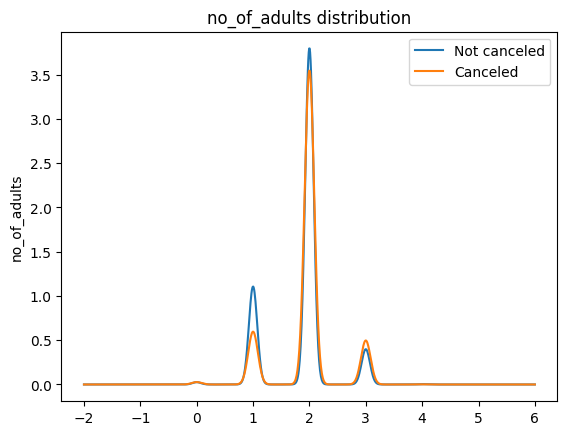

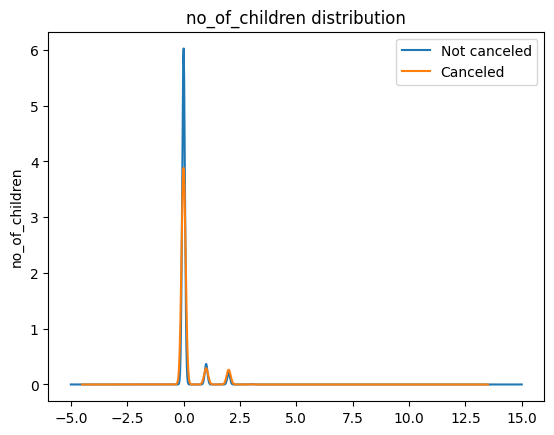

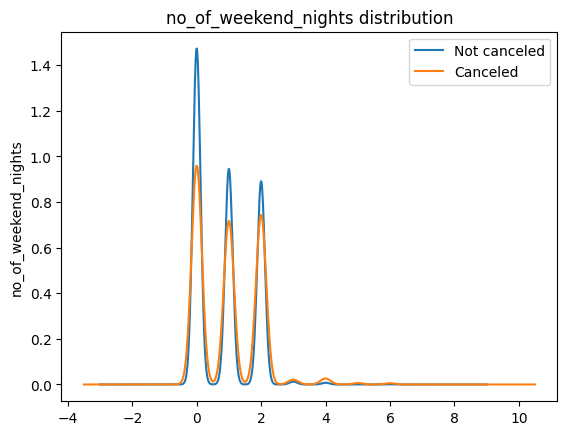

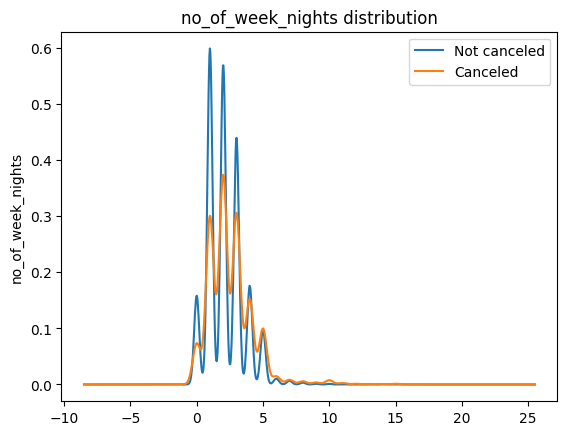

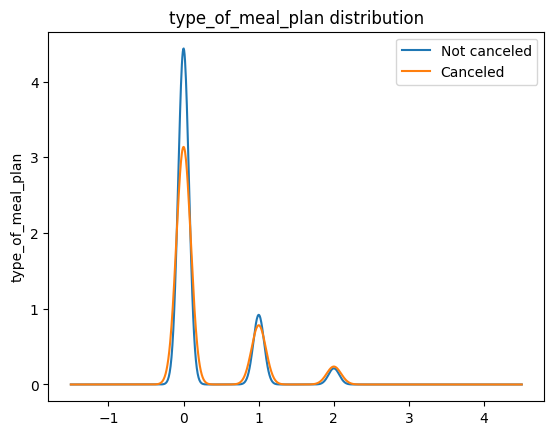

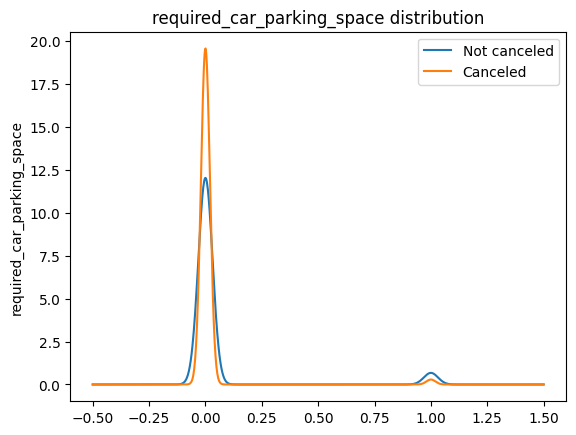

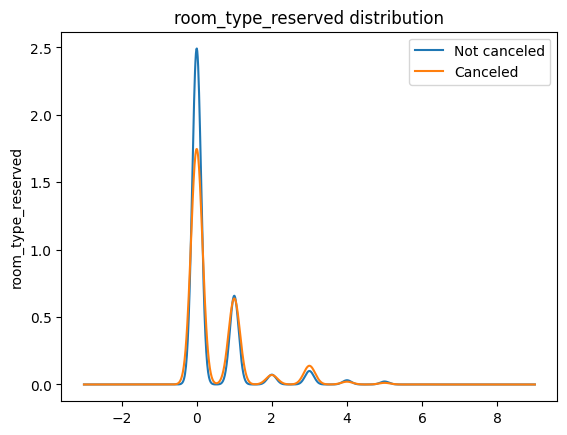

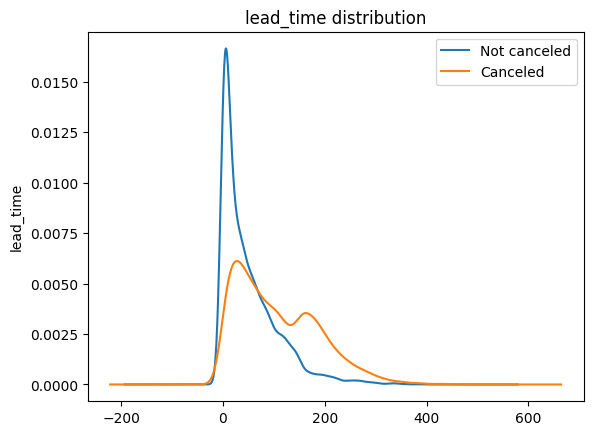

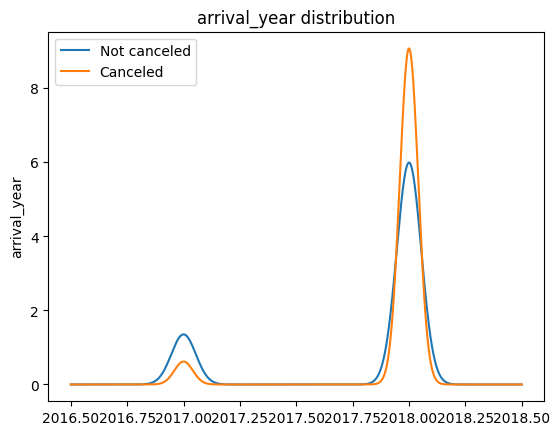

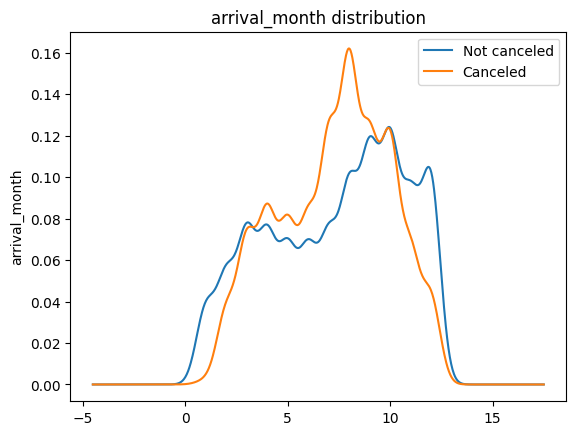

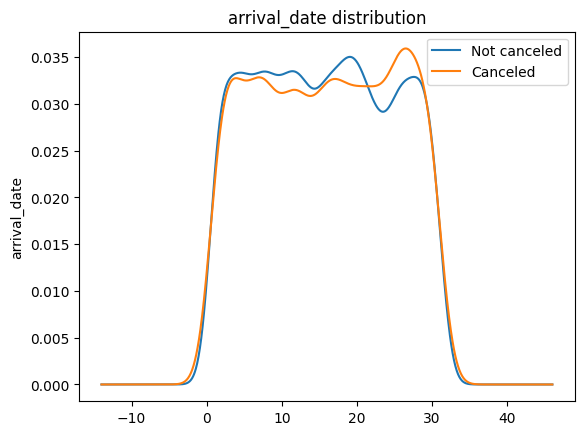

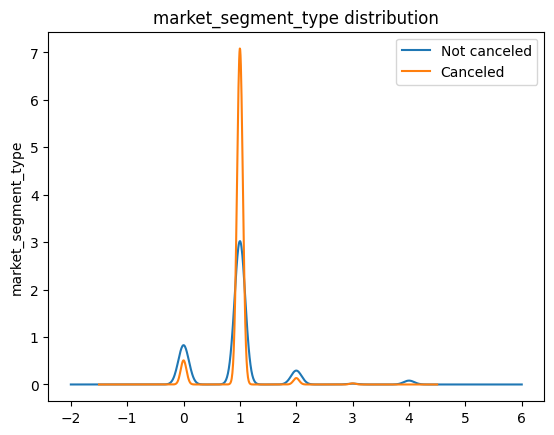

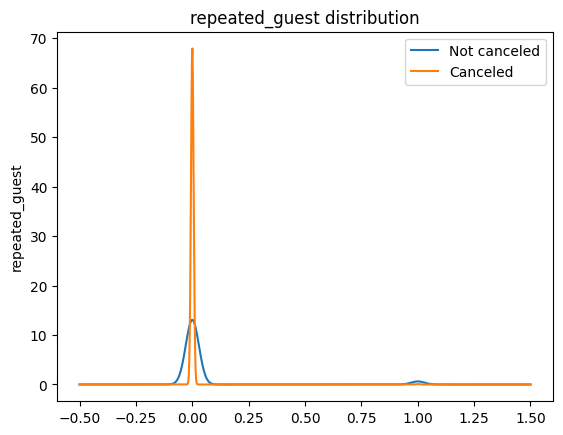

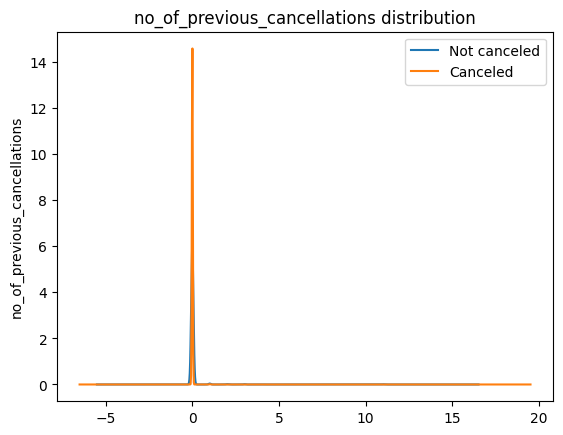

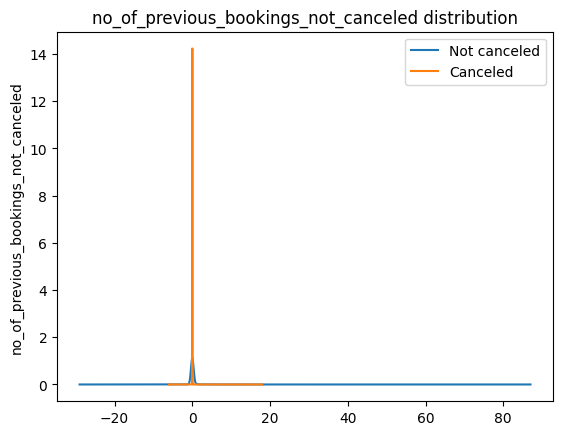

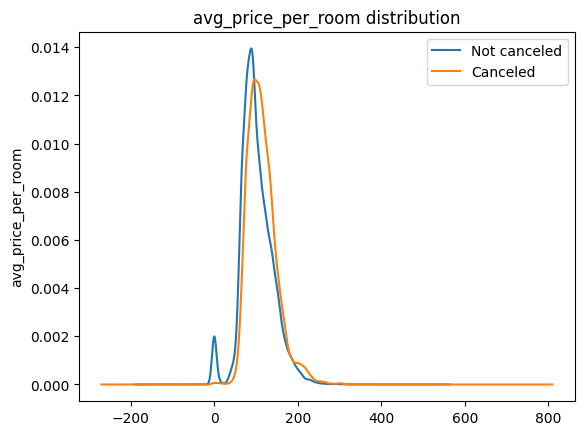

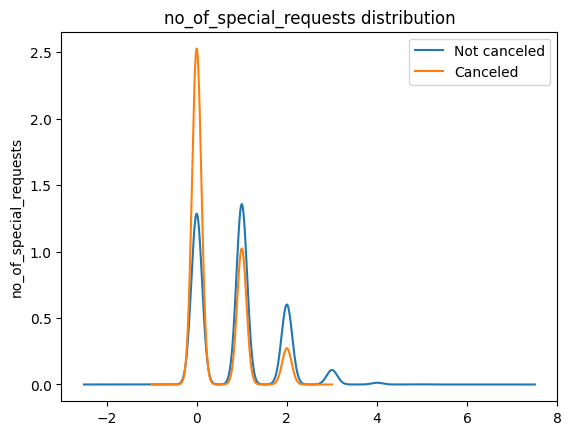

In [13]:
plot_distribution(df, feature_columns)

### Analisando box plot
É possível observar uma elevada quantidade de outliers para serem tratados.

In [14]:
def standardizer_boxplot(data, columns):
   
    scaler = StandardScaler().fit(data[columns])
    standardized = pd.DataFrame(scaler.transform(data[columns]), columns = columns)

    plt.boxplot(standardized)
    plt.show()

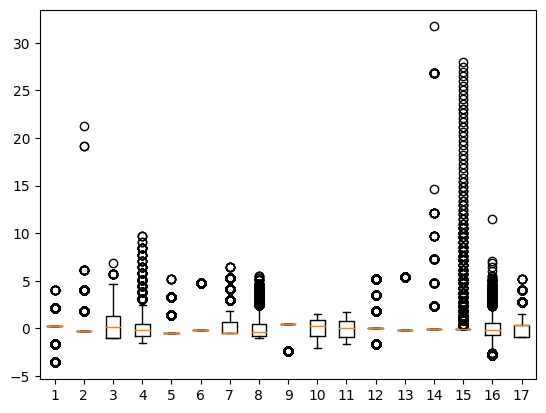

In [15]:
standardizer_boxplot(df, feature_columns)

In [16]:
def normalized_boxplot(data, columns):

    normalized = preprocessing.normalize(data[columns], axis = 0)
    normalized = pd.DataFrame(normalized, columns = columns)

    plt.boxplot(normalized)
    plt.show()

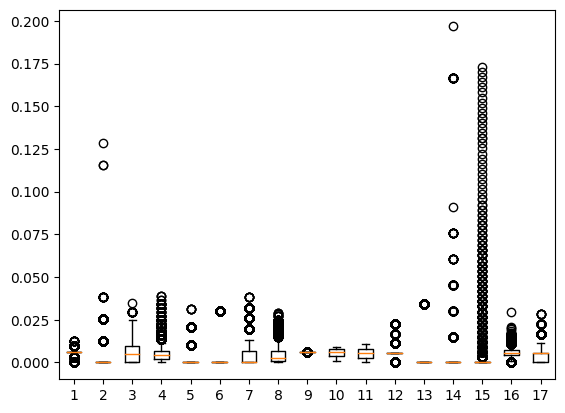

In [17]:
normalized_boxplot(df, feature_columns)

### Seleção de atributos

#### Matriz de correlação

In [18]:
corr = df.corr()
sorted_corr = corr[['booking_status']].sort_values(by = 'booking_status', ascending = True)
sorted_corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)

,booking_status
no_of_special_requests,-0.26
repeated_guest,-0.11
required_car_parking_space,-0.09
no_of_previous_bookings_not_canceled,-0.06
no_of_previous_cancellations,-0.04
arrival_month,-0.01
arrival_date,0.01
market_segment_type,0.01
type_of_meal_plan,0.05
room_type_reserved,0.06


#### Calculando variância

In [19]:
normalized = preprocessing.normalize(df[feature_columns], axis = 0)
normalized = pd.DataFrame(normalized, columns = feature_columns)

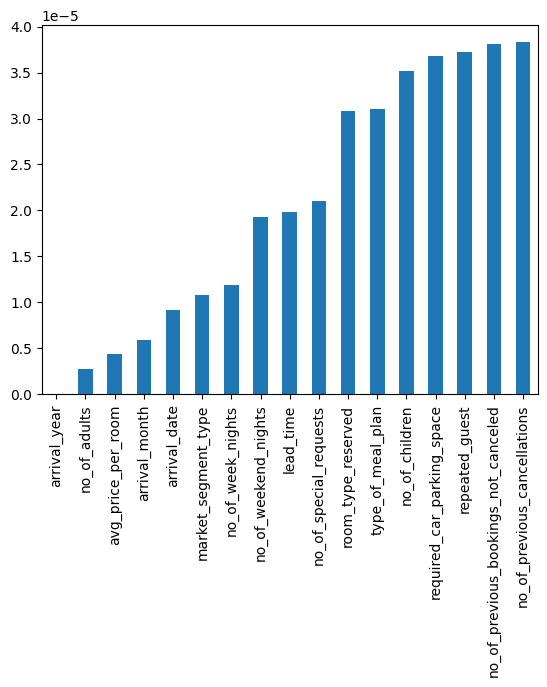

In [20]:
df_var = normalized.var().sort_values()
df_var.plot.bar()
plt.show()

Dado que a coluna "arrival_year" possui variância igual à 0, ela será retirada por não conter informações relevantes para os modelos.

In [21]:
selected_feature_columns = df_var.index[1:]

df_selected_features = df[selected_feature_columns].assign(
    booking_status = df['booking_status']
)
df_selected_features.head()

,no_of_adults,avg_price_per_room,arrival_month,arrival_date,market_segment_type,no_of_week_nights,no_of_weekend_nights,lead_time,no_of_special_requests,room_type_reserved,type_of_meal_plan,no_of_children,required_car_parking_space,repeated_guest,no_of_previous_bookings_not_canceled,no_of_previous_cancellations,booking_status
0,2,65.00,10,2,0,2,1,224,0,0,0,0,0,0,0,0,0
1,2,106.68,11,6,1,3,2,5,1,0,1,0,0,0,0,0,0
2,1,60.00,2,28,1,1,2,1,0,0,0,0,0,0,0,0,1
3,2,100.00,5,20,1,2,0,211,0,0,0,0,0,0,0,0,1
4,2,94.50,4,11,1,1,1,48,0,0,1,0,0,0,0,0,1


### Remoção de outliers
A análise de outliers é feita por [distância interquartil](https://pt.economy-pedia.com/11035383-interquartile-range#:~:text=O%20intervalo%20interquartil%20%C3%A9%20uma,usada%20no%20gr%C3%A1fico%20de%20caixa.).

In [22]:
def remove_outliers(data):
    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    
    inferior_limit = q1 - 1.5 * iqr
    superior_limit = q3 + 1.5 * iqr
    
    acceptable_values = ~((data < inferior_limit) | (data > superior_limit)).any(axis = 1)
    data_filtered = data[acceptable_values]
    
    return data_filtered

A função abaixo realiza a remoção a partir dos dados agrupados com base em sua classificação. Dessa forma, é possível manter as distribuições por atributos.

In [23]:
def remove_outliers_by_classification(data, classification):
    return data.groupby(
        classification
    ).apply(
        remove_outliers
    ).reset_index(drop = True)

In [24]:
df_filtered = remove_outliers_by_classification(
    df_selected_features,
    'booking_status'
)

Foram encontrados 17.848 outliers.

In [25]:
df.shape[0] - df_filtered.shape[0]

17848

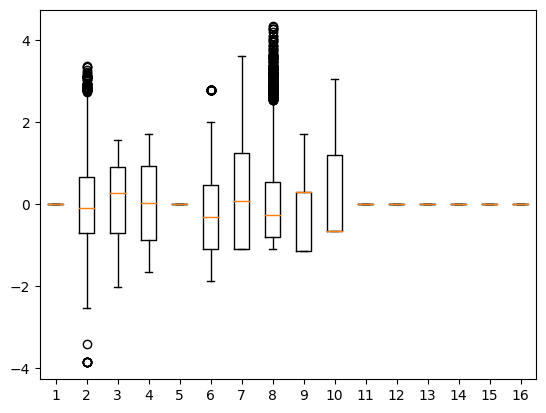

In [26]:
standardizer_boxplot(df_filtered, selected_feature_columns)

## Classificação

### Variáveis globais

In [27]:
TEST_SIZE = 1/3
RANDOM_STATE = 4242564

### Divisão em treino e teste

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_filtered.drop(['booking_status'], axis = 1),
    df_filtered['booking_status'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

### Support Vector Machine - SVM
Realizado com base nos slides da Aula 5 - SVM

In [29]:
def train_svc(x_train, x_test, y_train, y_test):
    
    scaler = MinMaxScaler()
    model = SVC(random_state = RANDOM_STATE, gamma = 'auto')
    
    svc_pipeline = Pipeline(
        steps = [
            ('scaler', scaler),
            ('svc',  model)
        ]
    )
    svc_pipeline.fit(x_train.values, y_train.values)
    
    y_pred = model.predict(x_test.values)
    
    print(classification_report(y_test, y_pred, zero_division = 1))
    
    ConfusionMatrixDisplay.from_estimator(svc_pipeline, x_test, y_test)
    plt.show()

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1739
           1       0.36      1.00      0.53       979

    accuracy                           0.36      2718
   macro avg       0.68      0.50      0.26      2718
weighted avg       0.77      0.36      0.19      2718



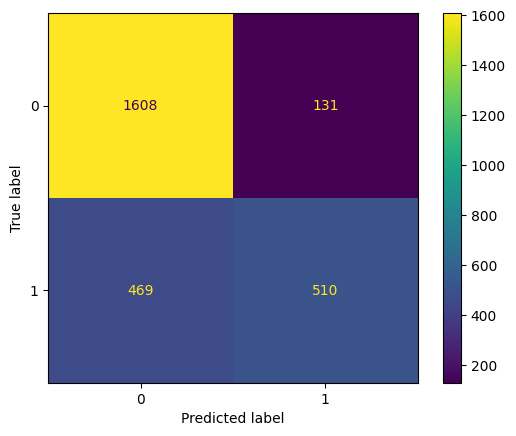

In [30]:
train_svc(X_train, X_test, Y_train, Y_test)

### Naive Bayes
Realizado com base nos slides da Aula 6 - Naive Bayes \
Comentar sobre https://stats.stackexchange.com/questions/254723/standardisation-in-naive-bayes

In [31]:
def train_naive_bayes(x_train, x_test, y_train, y_test):
    
    model = MultinomialNB()
    
    naive_bayes_pipeline = Pipeline(steps = [('naive bayes', model)])
    naive_bayes_pipeline.fit(x_train.values, y_train.values)
    
    y_pred = model.predict(x_test.values)
    
    print(classification_report(y_test, y_pred, zero_division =  1))
    
    disp = ConfusionMatrixDisplay.from_estimator(naive_bayes_pipeline, x_test, y_test)
    plt.show()

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1739
           1       0.55      0.60      0.58       979

    accuracy                           0.68      2718
   macro avg       0.66      0.66      0.66      2718
weighted avg       0.69      0.68      0.68      2718



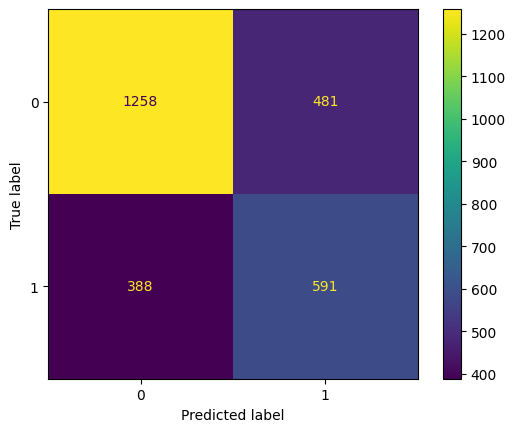

In [32]:
train_naive_bayes(X_train, X_test, Y_train, Y_test)

### Árvore de Decisão

In [33]:
def train_arvore_decisao(x_train, x_test, y_train, y_test):
    
    tree = DecisionTreeClassifier(random_state = RANDOM_STATE)
    cost = tree.cost_complexity_pruning_path(x_train, y_train)

    ccp_alphas = cost['ccp_alphas']
    trees = []

    max_tree_score = 0
    best_tree = -1
    best_y_pred = -1
    for ccp_alpha in ccp_alphas:
        tree = DecisionTreeClassifier(random_state = RANDOM_STATE, ccp_alpha = ccp_alpha)
        tree.fit(x_train, y_train)
        tree_score = tree.score(x_test.values,y_test.values)
        if tree_score > max_tree_score:
            best_tree = tree
            best_y_pred = tree.predict(x_test.values)
        trees.append(tree_score)
    print(f'Melhor pruning = {ccp_alphas[np.argmax(trees)]}')
    
    print(classification_report(y_test, best_y_pred, zero_division = 1))    
    
    disp = ConfusionMatrixDisplay.from_estimator(best_tree, x_test, y_test)
    plt.show()

Melhor pruning = 0.0005886451494309157
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1739
           1       1.00      0.00      0.00       979

    accuracy                           0.64      2718
   macro avg       0.82      0.50      0.39      2718
weighted avg       0.77      0.64      0.50      2718



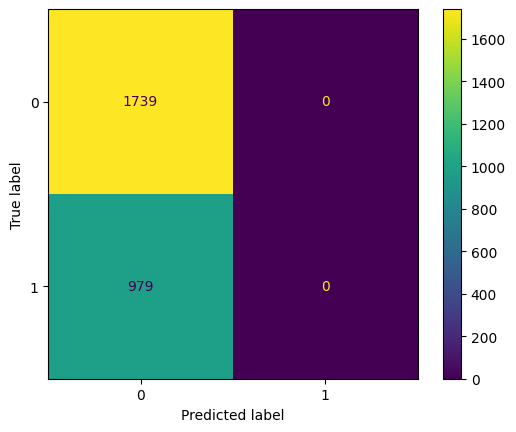

In [34]:
train_arvore_decisao(X_train, X_test, Y_train, Y_test)

### KNN

In [35]:
def train_knn(x_train, x_test, y_train, y_test):
    
    train_size = len(x_train.index)
    
    knncs = []

    best_knnc = -1
    best_knnc_score = -1
    best_y_pred = -1
    
    for index in range(1, int(np.sqrt(train_size))):
        knnc = KNeighborsClassifier(n_neighbors = index)
        knnc.fit(x_train, y_train)
        knnc_score = knnc.score(x_test.values,y_test.values)
        if knnc_score > best_knnc_score:
            best_knnc = knnc
            best_y_pred = knnc.predict(x_test.values)
            best_knnc_score = knnc_score
        knncs.append(knnc_score)
        
    print(classification_report(y_test, best_y_pred, zero_division = 1))    
    disp = ConfusionMatrixDisplay.from_estimator(best_knnc, x_test, y_test)
    plt.show()

              precision    recall  f1-score   support

           0       0.73      0.95      0.82      1739
           1       0.80      0.38      0.52       979

    accuracy                           0.74      2718
   macro avg       0.76      0.66      0.67      2718
weighted avg       0.76      0.74      0.71      2718



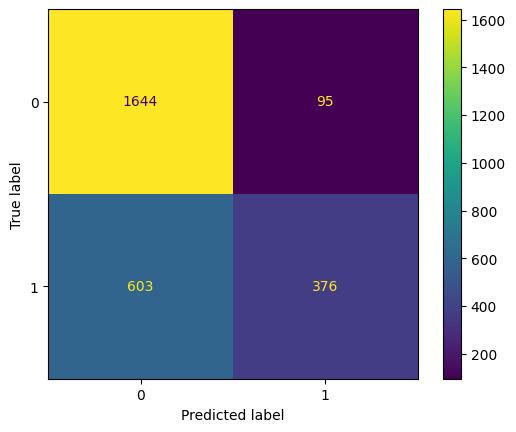

In [36]:
train_knn(X_train, X_test, Y_train, Y_test)

### Regressão Logística

In [37]:
grid_param = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [38]:
def train_reg_log(x_train, x_test, y_train, y_test):
    
    lr = LogisticRegression(random_state = RANDOM_STATE)
    lr = GridSearchCV(lr, param_grid = grid_param)
    lr.fit(x_train, y_train)
    
    y_pred = lr.predict(x_test.values)
        
    print(classification_report(y_test, y_pred, zero_division = 1))    
    
    disp = ConfusionMatrixDisplay.from_estimator(lr, x_test, y_test)
    plt.show()

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1739
           1       0.74      0.58      0.65       979

    accuracy                           0.78      2718
   macro avg       0.76      0.73      0.74      2718
weighted avg       0.77      0.78      0.77      2718



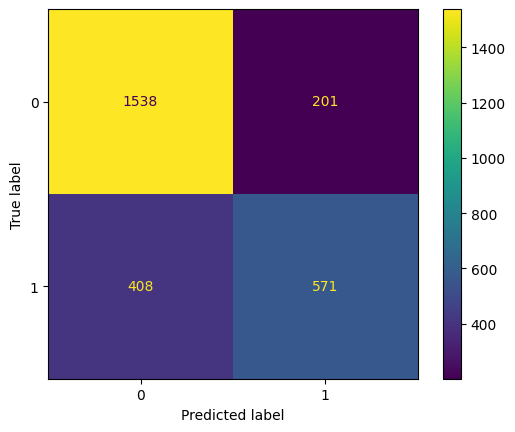

In [39]:
train_reg_log(X_train, X_test, Y_train, Y_test)

## Comparando resultados
Comentar sobre https://datascience.stackexchange.com/questions/109989/how-do-outliers-and-missing-values-impact-these-classifiers

### Utilizando dataset inteiro (todos os atributos e com outliers)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df.drop(['booking_status'], axis = 1),
    df['booking_status'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

In [41]:
def compare_models(x_train, x_test, y_train, y_test):
    
    print('=' * 10 + ' SVM '+ '=' * 10)
    train_svc(x_train, x_test, y_train, y_test)
    
    print('\n\n' + '=' * 10 + ' Naive Bayes '+ '=' * 10)
    train_naive_bayes(x_train, x_test, y_train, y_test)
    
    print('\n\n' + '=' * 10 + ' Árvore de Decisão '+ '=' * 10)
    train_arvore_decisao(x_train, x_test, y_train, y_test)
        
    print('\n\n' + '=' * 10 + ' KNN '+ '=' * 10)
    train_knn(x_train, x_test, y_train, y_test)
    
    print('\n\n' + '=' * 10 + ' Regressão Logística '+ '=' * 10)
    train_reg_log(x_train, x_test, Y_train, y_test)

========== SVM ==========
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      6157
           1       1.00      0.00      0.00      2510

    accuracy                           0.71      8667
   macro avg       0.86      0.50      0.42      8667
weighted avg       0.79      0.71      0.59      8667



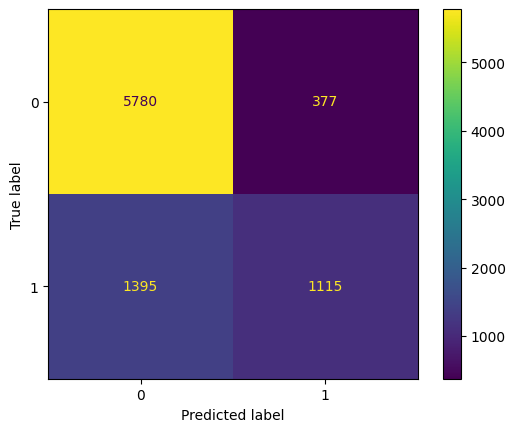



========== Naive Bayes ==========
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      6157
           1       0.48      0.56      0.51      2510

    accuracy                           0.69      8667
   macro avg       0.64      0.65      0.65      8667
weighted avg       0.71      0.69      0.70      8667



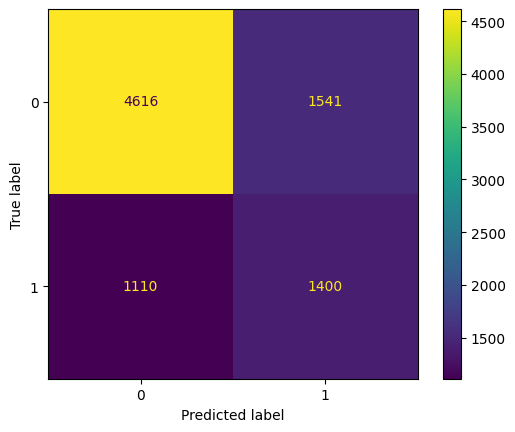



========== Árvore de Decisão ==========
Melhor pruning = 0.000201547135142012
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      6157
           1       1.00      0.00      0.00      2510

    accuracy                           0.71      8667
   macro avg       0.86      0.50      0.42      8667
weighted avg       0.79      0.71      0.59      8667



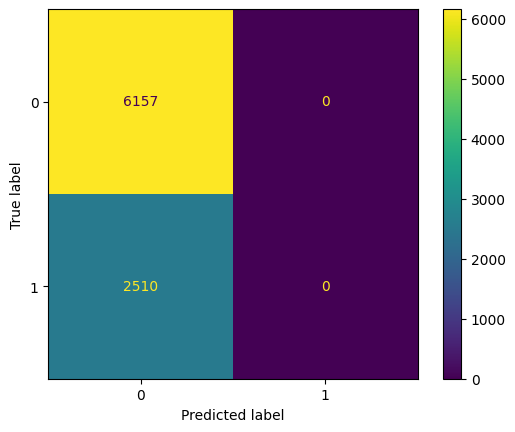



========== KNN ==========
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      6157
           1       0.75      0.30      0.42      2510

    accuracy                           0.77      8667
   macro avg       0.76      0.63      0.64      8667
weighted avg       0.76      0.77      0.73      8667



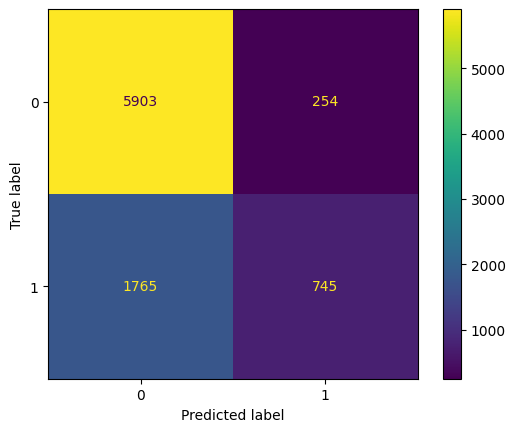



========== Regressão Logística ==========
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      6157
           1       0.69      0.47      0.56      2510

    accuracy                           0.79      8667
   macro avg       0.75      0.69      0.71      8667
weighted avg       0.78      0.79      0.77      8667



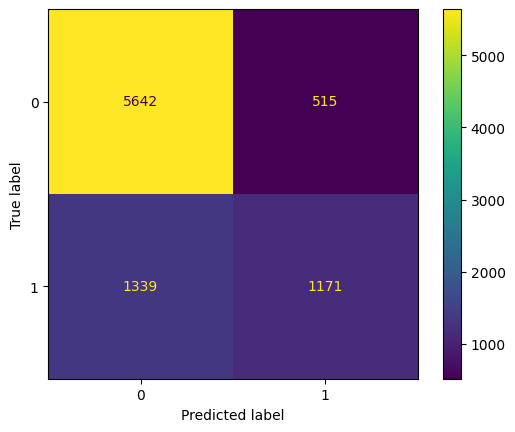

In [42]:
compare_models(X_train, X_test, Y_train, Y_test)

### Utilizando dataset cujos atributos possuem variância maior do que zero (com outliers)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_selected_features.drop(['booking_status'], axis = 1),
    df_selected_features['booking_status'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

========== SVM ==========
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      6157
           1       1.00      0.00      0.00      2510

    accuracy                           0.71      8667
   macro avg       0.86      0.50      0.42      8667
weighted avg       0.79      0.71      0.59      8667



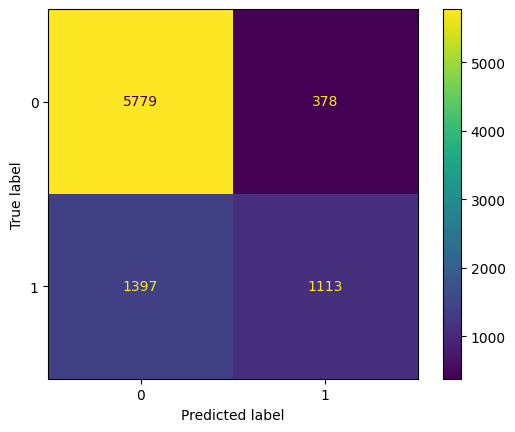



========== Naive Bayes ==========
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      6157
           1       0.45      0.56      0.50      2510

    accuracy                           0.68      8667
   macro avg       0.63      0.64      0.63      8667
weighted avg       0.70      0.68      0.68      8667



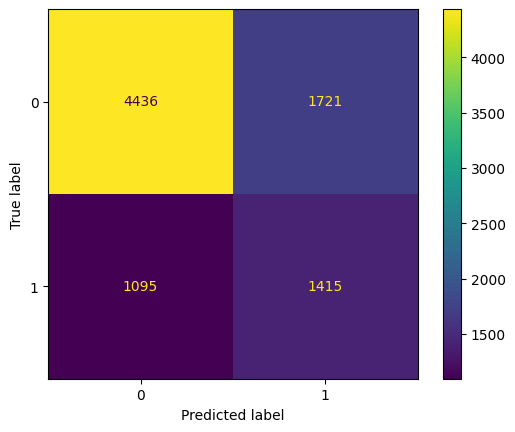



========== Árvore de Decisão ==========
Melhor pruning = 0.00021834386172137153
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      6157
           1       1.00      0.00      0.00      2510

    accuracy                           0.71      8667
   macro avg       0.86      0.50      0.42      8667
weighted avg       0.79      0.71      0.59      8667



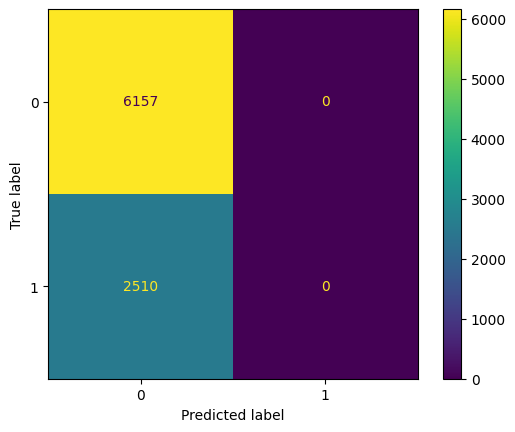



========== KNN ==========
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      6157
           1       0.75      0.30      0.43      2510

    accuracy                           0.77      8667
   macro avg       0.76      0.63      0.64      8667
weighted avg       0.76      0.77      0.73      8667



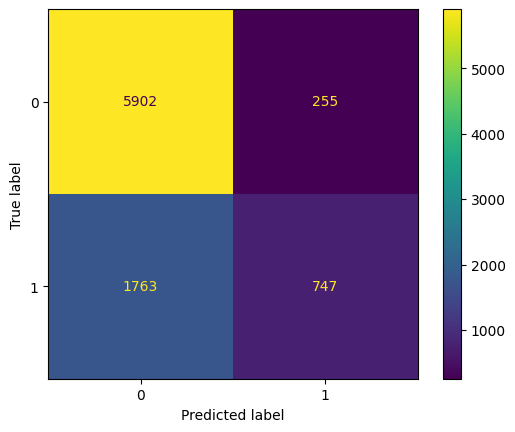



========== Regressão Logística ==========
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      6157
           1       0.71      0.42      0.53      2510

    accuracy                           0.78      8667
   macro avg       0.75      0.68      0.69      8667
weighted avg       0.77      0.78      0.76      8667



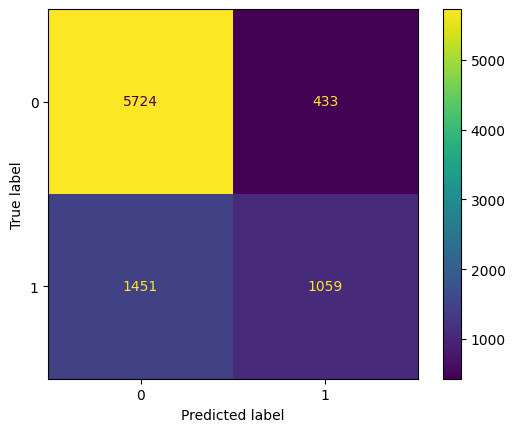

In [44]:
compare_models(X_train, X_test, Y_train, Y_test)

### Utilizando dataset cujos atributos possuem variância maior do que um (com outliers)

Relembrando...

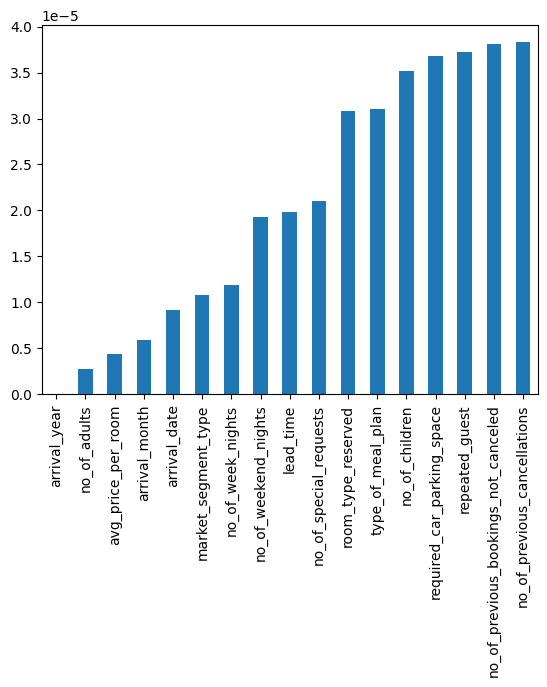

In [45]:
df_var = normalized.var().sort_values()
df_var.plot.bar()
plt.show()

Para os resultados a seguir, não utilizaremos as quatro primeiras colunas.

In [46]:
selected_feature_columns = df_var.index[4:]

df_selected_features = df[selected_feature_columns].assign(
    booking_status = df['booking_status']
)

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_selected_features.drop(['booking_status'], axis = 1),
    df_selected_features['booking_status'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

========== SVM ==========
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      6157
           1       0.16      0.00      0.00      2510

    accuracy                           0.71      8667
   macro avg       0.43      0.50      0.42      8667
weighted avg       0.55      0.71      0.59      8667



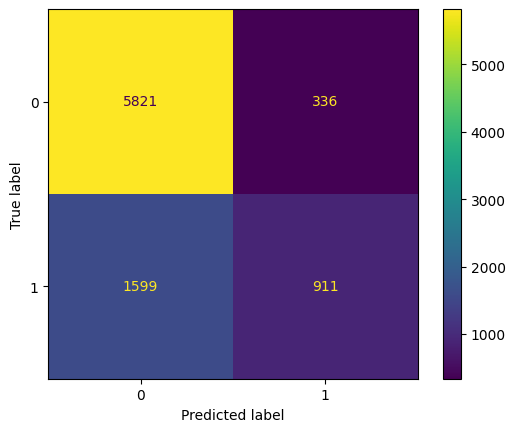



========== Naive Bayes ==========
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      6157
           1       0.46      0.59      0.52      2510

    accuracy                           0.68      8667
   macro avg       0.64      0.66      0.64      8667
weighted avg       0.71      0.68      0.69      8667



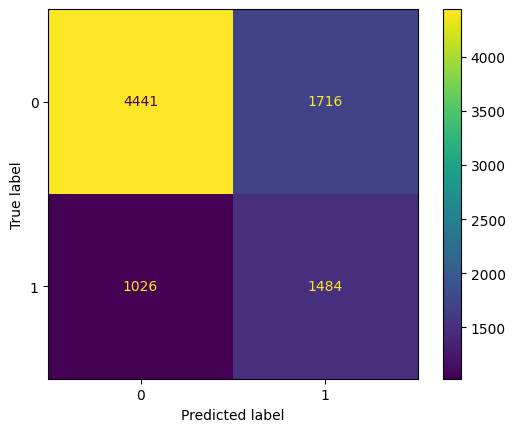



========== Árvore de Decisão ==========
Melhor pruning = 0.00022486310977376384
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      6157
           1       1.00      0.00      0.00      2510

    accuracy                           0.71      8667
   macro avg       0.86      0.50      0.42      8667
weighted avg       0.79      0.71      0.59      8667



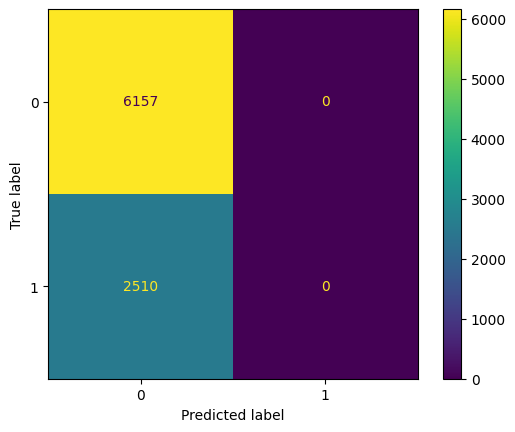



========== KNN ==========
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      6157
           1       0.70      0.31      0.43      2510

    accuracy                           0.76      8667
   macro avg       0.73      0.63      0.64      8667
weighted avg       0.75      0.76      0.73      8667



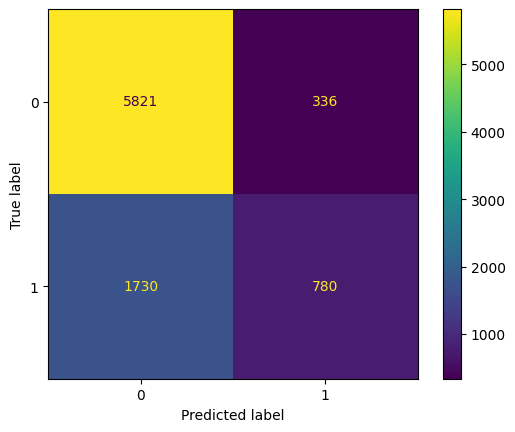



========== Regressão Logística ==========
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      6157
           1       0.68      0.41      0.51      2510

    accuracy                           0.77      8667
   macro avg       0.74      0.67      0.68      8667
weighted avg       0.76      0.77      0.75      8667



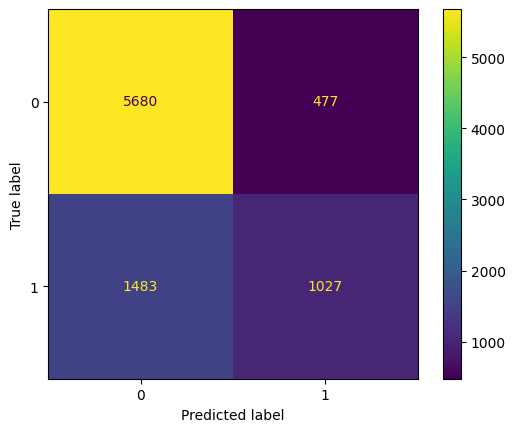

In [48]:
compare_models(X_train, X_test, Y_train, Y_test)

### Utilizando dataset cujos atributos possuem variância maior do que um e sem outliers

In [49]:
df_filtered = remove_outliers_by_classification(
    df_selected_features,
    'booking_status'
)

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_filtered.drop(['booking_status'], axis = 1),
    df_filtered['booking_status'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

========== SVM ==========
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      2497
           1       0.34      1.00      0.51      1305

    accuracy                           0.35      3802
   macro avg       0.67      0.50      0.26      3802
weighted avg       0.77      0.35      0.18      3802



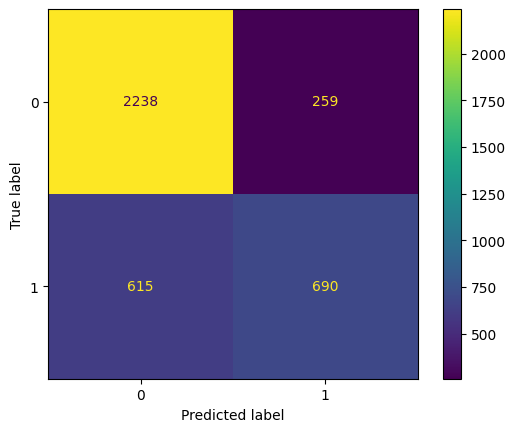



========== Naive Bayes ==========
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2497
           1       0.55      0.60      0.57      1305

    accuracy                           0.69      3802
   macro avg       0.66      0.67      0.67      3802
weighted avg       0.70      0.69      0.69      3802



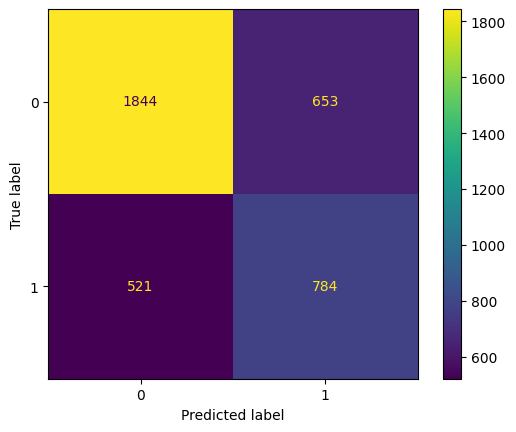



========== Árvore de Decisão ==========
Melhor pruning = 0.0005164382005296749
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      2497
           1       1.00      0.00      0.00      1305

    accuracy                           0.66      3802
   macro avg       0.83      0.50      0.40      3802
weighted avg       0.77      0.66      0.52      3802



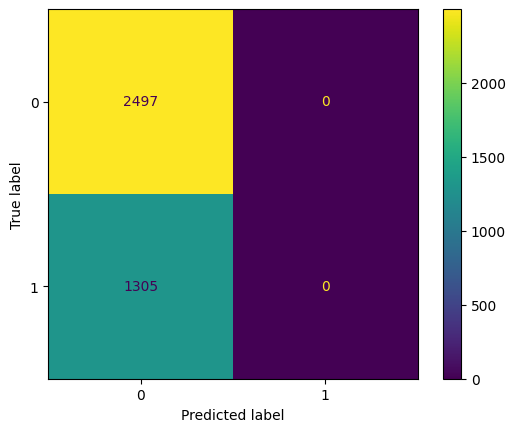



========== KNN ==========
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      2497
           1       0.85      0.34      0.48      1305

    accuracy                           0.75      3802
   macro avg       0.79      0.65      0.66      3802
weighted avg       0.77      0.75      0.72      3802



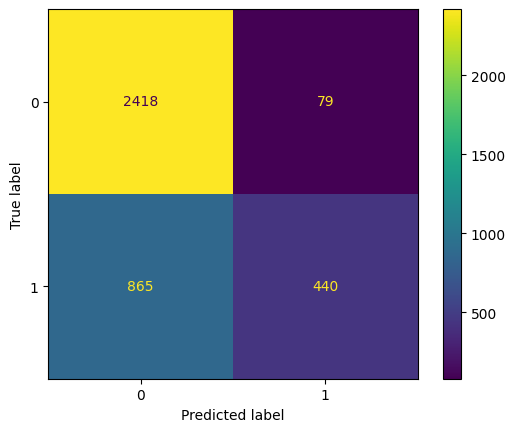



========== Regressão Logística ==========
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      2497
           1       0.70      0.56      0.62      1305

    accuracy                           0.77      3802
   macro avg       0.75      0.72      0.73      3802
weighted avg       0.76      0.77      0.76      3802



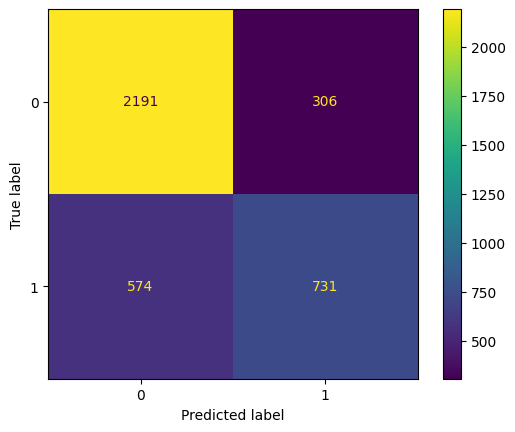

In [51]:
compare_models(X_train, X_test, Y_train, Y_test)